![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/90.2.Financial_Visual_NER.ipynb)

# Financial Visual Document Understanding

In [ ]:
import numpy
numpy.__version__

'1.22.4'

In [ ]:
import transformers
transformers.__version__

'4.28.1'

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import *

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

In [ ]:
! pip install -U numpy

In [ ]:
! pip install --upgrade scikit-image==0.19.3

In [ ]:
! pip install transformers==4.21.3 

In [ ]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.transformers import *

In [ ]:
from johnsnowlabs import nlp, finance, visual
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

# Download Images

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/t01.jpg
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/t02.jpg
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/t03.jpg
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/test0.jpeg

# Visual NER on 10K Filings (SEC)

This model is a Visual NER team aimed to extract the main key points in the summary page of SEC 10 K filings (Annual reports).

In [ ]:
binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

img_to_hocr = visual.ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = visual.HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = visual.VisualDocumentNerV21()\
    .pretrained("visualner_10kfilings", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

draw = visual.ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(visual.Color.red)

# OCR pipeline
pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    draw
])



visualner_10kfilings download started this may take some time.
Approximate size to download 709.9 MB


### Example-1

In [ ]:
! python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import pyspark.sql.functions as F
import pkg_resources
bin_df = spark.read.format("binaryFile").load('/content/t01.jpg')
bin_df.show()

results = pipeline.transform(bin_df).cache()

res = results.collect()

## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = F.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/t01...|2023-05-10 15:19:...|183575|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|filename|exploded_entities                                                                                                                              |
+--------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|t01.jpg |{named_entity, 0, 0, OTHERS, {confidence -> 96, width -> 66, x -> 17, y -> 199, word -> (Mark, token -> (, height -> 24}, []}                  |
|t01.jpg |{named_en


    Image #0:
    Origin: file:/content/t01.jpg
    Resolution: 0 dpi
    Width: 3129 px
    Height: 1373 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


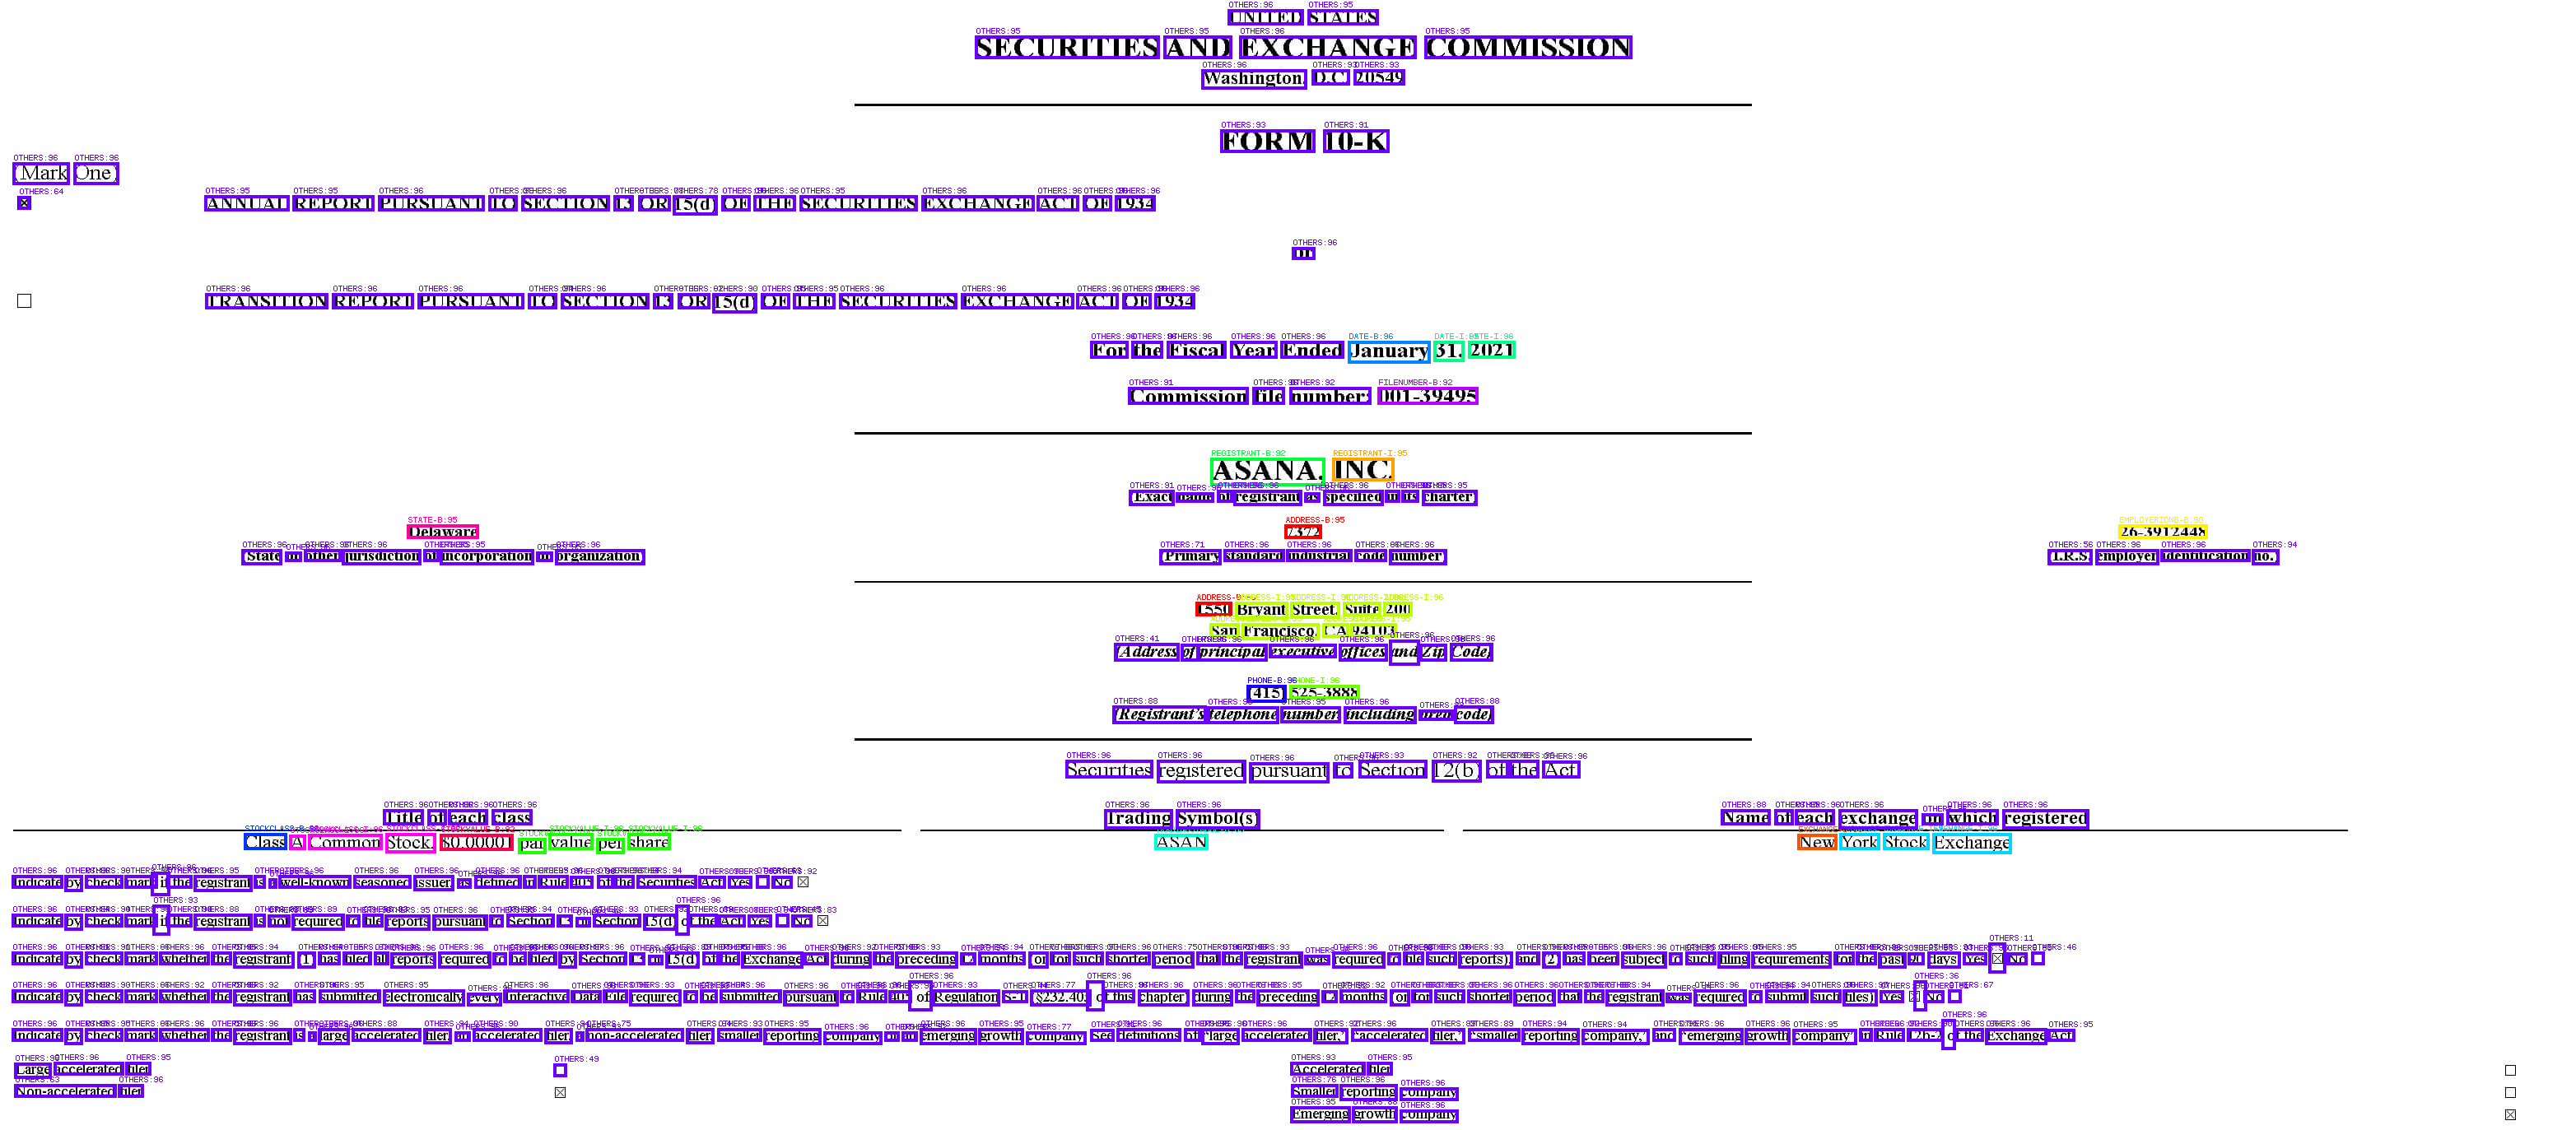

In [ ]:
visual.display_images(results, "image_with_annotations", width=1000)

In [ ]:
results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities.result")\
    .distinct().show(truncate=False)

+--------+---------------+
|filename|result         |
+--------+---------------+
|t01.jpg |STOCKVALUE-I   |
|t01.jpg |TRADINGSYMBOL-B|
|t01.jpg |REGISTRANT-B   |
|t01.jpg |PHONE-I        |
|t01.jpg |ADDRESS-B      |
|t01.jpg |FILENUMBER-B   |
|t01.jpg |DATE-B         |
|t01.jpg |EXCHANGE-B     |
|t01.jpg |REGISTRANT-I   |
|t01.jpg |STATE-B        |
|t01.jpg |STOCKVALUE-B   |
|t01.jpg |STOCKCLASS-B   |
|t01.jpg |STOCKCLASS-I   |
|t01.jpg |ADDRESS-I      |
|t01.jpg |EMPLOYERIDNB-B |
|t01.jpg |EXCHANGE-I     |
|t01.jpg |OTHERS         |
|t01.jpg |DATE-I         |
|t01.jpg |PHONE-B        |
+--------+---------------+



### Example-2

In [ ]:

import pkg_resources
bin_df = spark.read.format("binaryFile").load('t02.jpg')
bin_df.show()

results = pipeline.transform(bin_df).cache()

res = results.collect()

## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = F.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/t02...|2023-05-10 15:19:...|160854|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+

+--------+------------------------------------------------------------------------------------------------------------------------------------------------+
|filename|exploded_entities                                                                                                                               |
+--------+------------------------------------------------------------------------------------------------------------------------------------------------+
|t02.jpg |{named_entity, 0, 5, OTHERS, {confidence -> 95, width -> 74, x -> 1507, y -> 30, word -> UNITED, token -> united, height -> 13}, []}            |
|t02.jpg |{name


    Image #0:
    Origin: file:/content/t02.jpg
    Resolution: 0 dpi
    Width: 2881 px
    Height: 1449 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


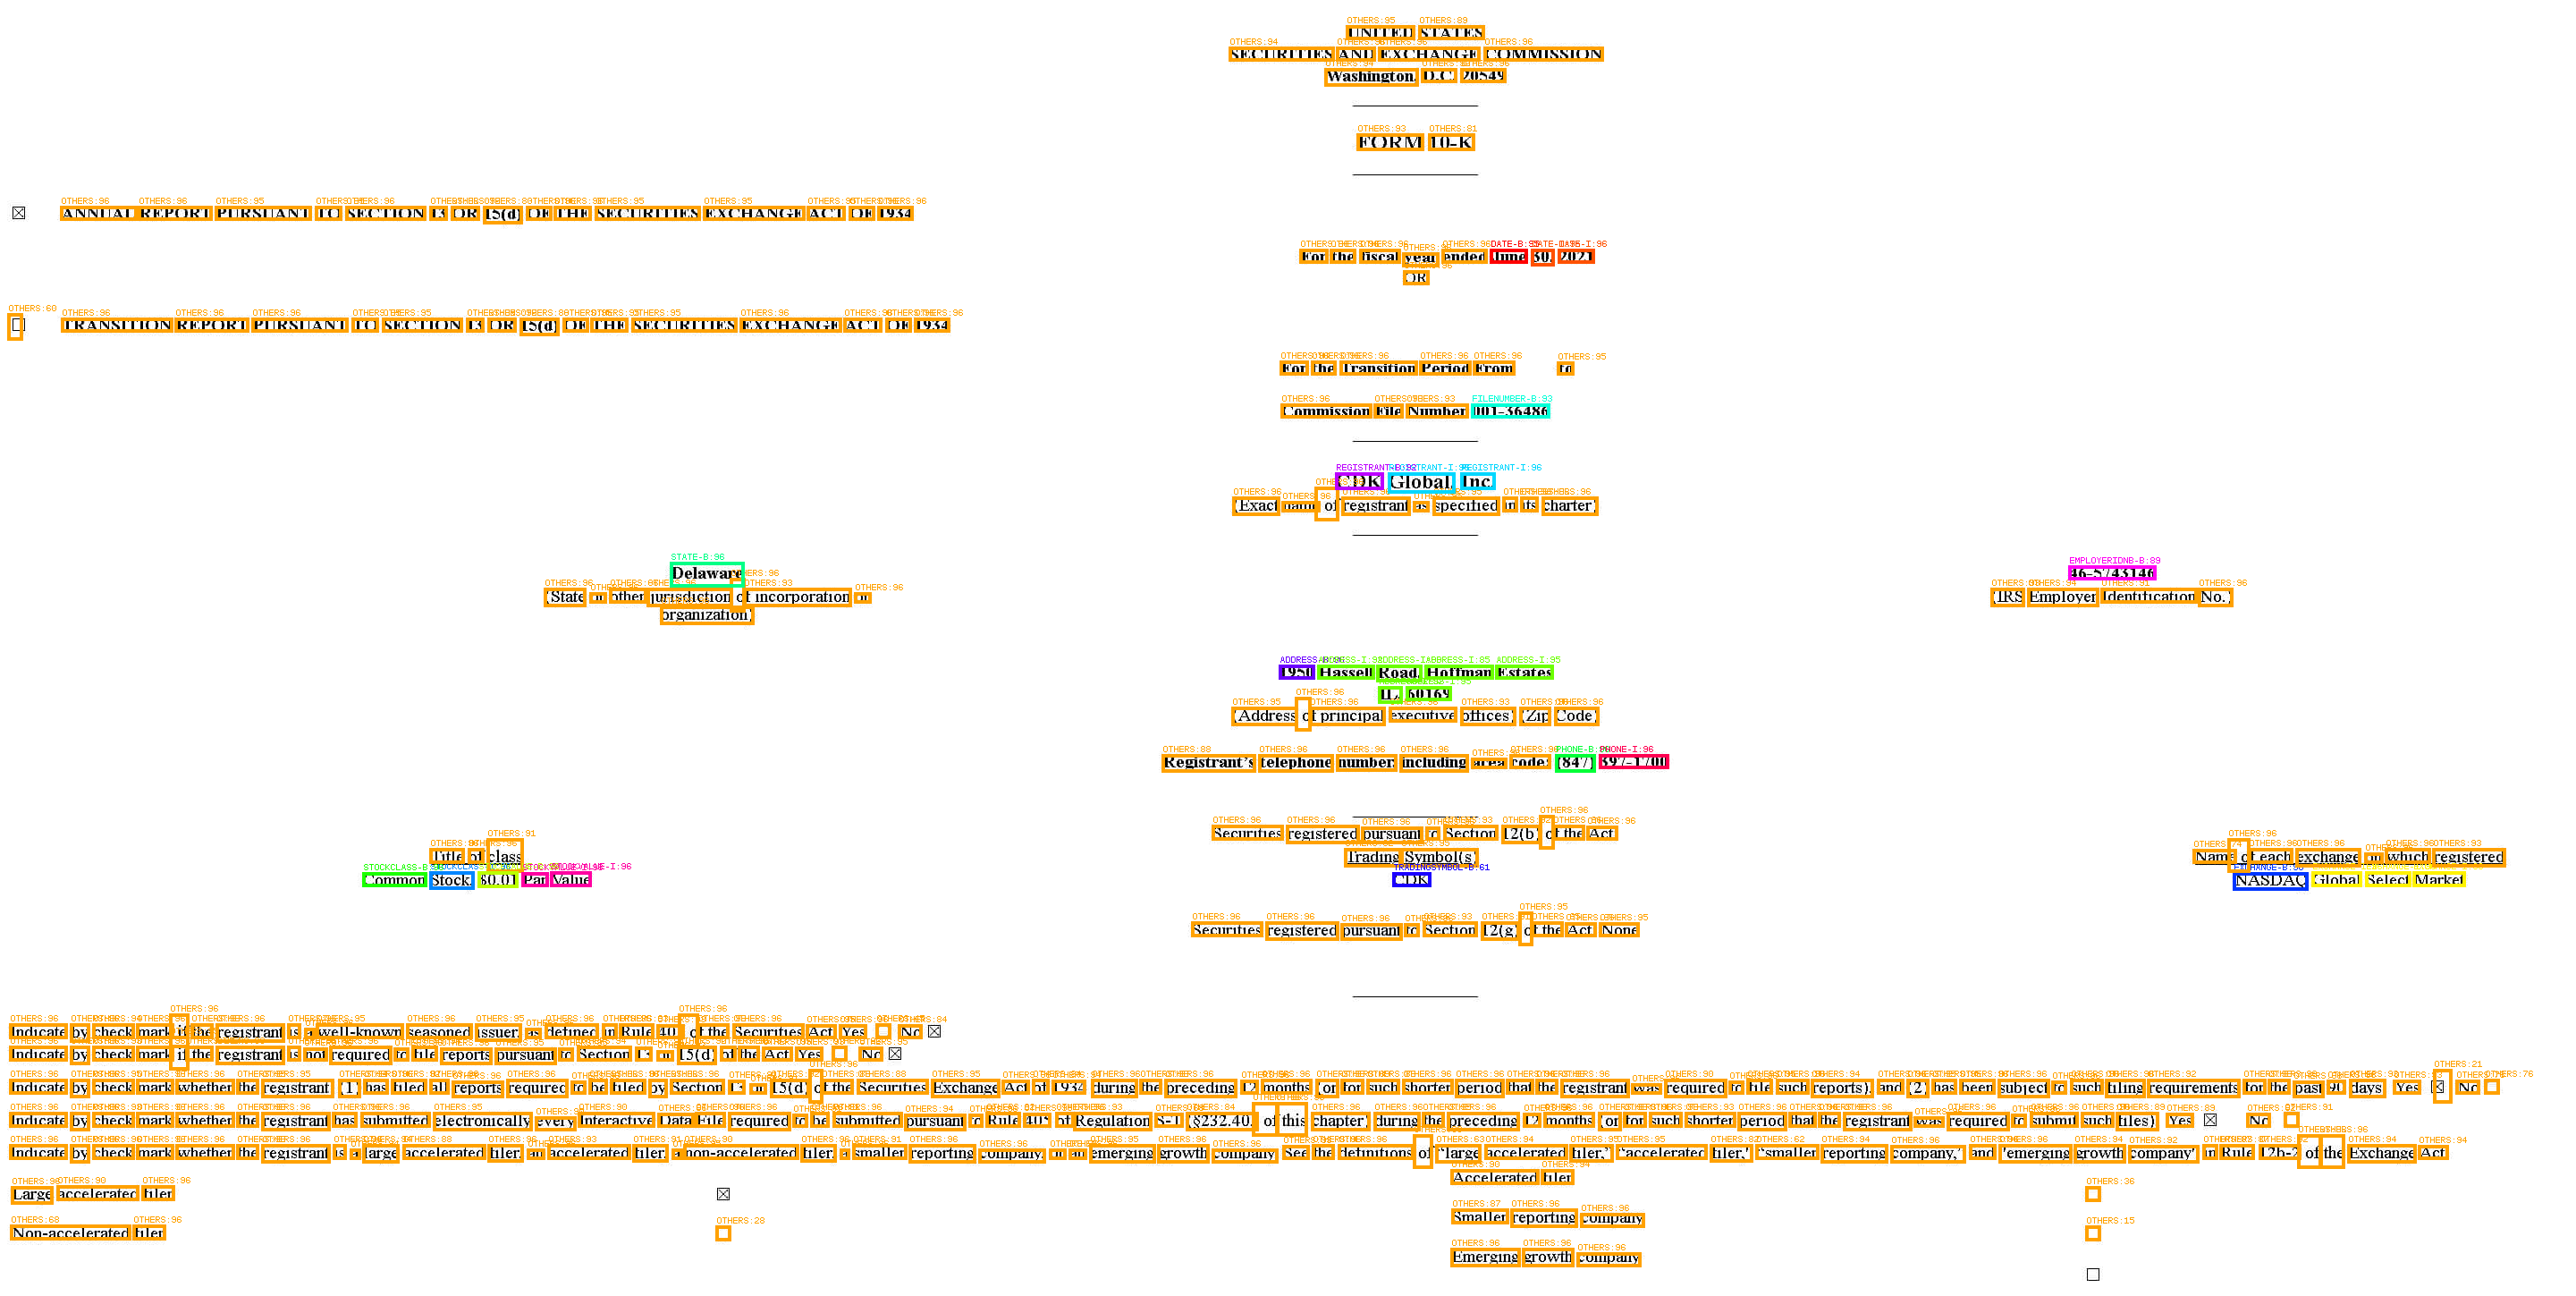

In [ ]:
visual.display_images(results, "image_with_annotations", width=1000)

In [ ]:
results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities.result")\
    .distinct().show(truncate=False)

+--------+---------------+
|filename|result         |
+--------+---------------+
|t02.jpg |ADDRESS-B      |
|t02.jpg |STOCKVALUE-B   |
|t02.jpg |PHONE-I        |
|t02.jpg |DATE-B         |
|t02.jpg |EMPLOYERIDNB-B |
|t02.jpg |FILENUMBER-B   |
|t02.jpg |REGISTRANT-B   |
|t02.jpg |REGISTRANT-I   |
|t02.jpg |STOCKCLASS-B   |
|t02.jpg |TRADINGSYMBOL-B|
|t02.jpg |OTHERS         |
|t02.jpg |STOCKCLASS-I   |
|t02.jpg |STATE-B        |
|t02.jpg |EXCHANGE-B     |
|t02.jpg |DATE-I         |
|t02.jpg |ADDRESS-I      |
|t02.jpg |PHONE-B        |
|t02.jpg |EXCHANGE-I     |
|t02.jpg |STOCKVALUE-I   |
+--------+---------------+



# Visual NER - CORD (Receipts)

This is a Visual NER, a model trained on the top of LayoutLMV2 to detect regions in Tickets. This model can be used after, for example, the Binary Image Classifier of Tickets, available at https://nlp.johnsnowlabs.com/2022/09/07/finvisualclf_vit_tickets_en.html

In [ ]:
binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

img_to_hocr = visual.ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = visual.HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = visual.VisualDocumentNerV21()\
    .pretrained("visualner_receipts", "xx", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

draw = visual.ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(visual.Color.red)

# OCR pipeline
pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    draw
])



visualner_receipts download started this may take some time.
Approximate size to download 709.9 MB


### Example-1

In [ ]:

import pkg_resources
bin_df = spark.read.format("binaryFile").load('test0.jpeg')
bin_df.show()

results = pipeline.transform(bin_df).cache()

res = results.collect()

## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = F.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/tes...|2023-05-10 16:36:...| 55939|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+

+----------+-------------------------------------------------------------------------------------------------------------------------------------------+
|filename  |exploded_entities                                                                                                                          |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------+
|test0.jpeg|{named_entity, 0, 2, OTHERS, {confidence -> 61, width -> 155, x -> 229, y -> 74, word -> gis, token -> gis, height -> 86}, []}             |
|test0.jpeg|{named_entity, 


    Image #0:
    Origin: file:/content/test0.jpeg
    Resolution: 0 dpi
    Width: 550 px
    Height: 732 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


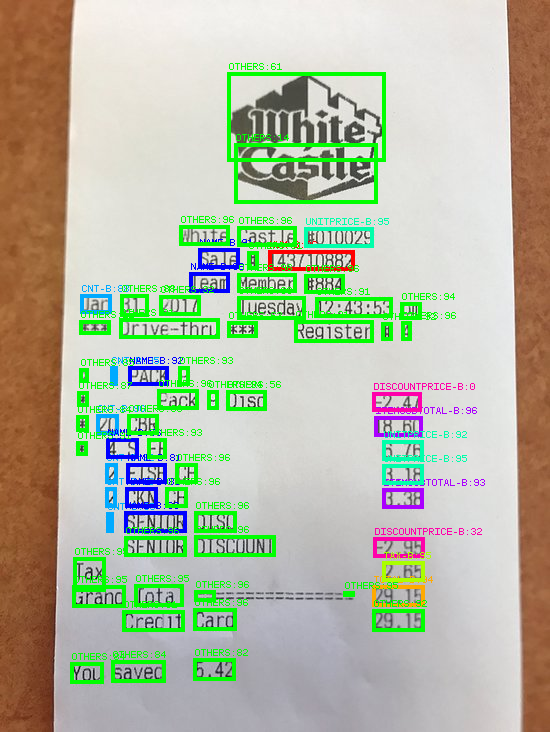

In [ ]:
visual.display_images(results, "image_with_annotations", width=1000)

In [ ]:
results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities.result")\
    .distinct().show(truncate=False)

+----------+---------------+
|filename  |result         |
+----------+---------------+
|test0.jpeg|OTHERS         |
|test0.jpeg|NUM-B          |
|test0.jpeg|ITEMSUBTOTAL-B |
|test0.jpeg|DISCOUNTPRICE-B|
|test0.jpeg|TAX-B          |
|test0.jpeg|CNT-B          |
|test0.jpeg|UNITPRICE-B    |
|test0.jpeg|TOTAL-B        |
|test0.jpeg|NAME-B         |
+----------+---------------+



# Key Value Recognition on 10K filings

This is a Form Recognition / Key Value extraction model, trained on the summary page of SEC 10K filings. It extracts KEY, VALUE or HEADER as entities, being HEADER the title on the filing.

In [ ]:
binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

img_to_hocr = visual.ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = visual.HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = visual.VisualDocumentNerV21()\
    .pretrained("visualner_keyvalue_10kfilings", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

draw = visual.ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(visual.Color.red)

# OCR pipeline
pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    draw
])



visualner_keyvalue_10kfilings download started this may take some time.
Approximate size to download 709.9 MB


### Example-1

In [ ]:

import pkg_resources
bin_df = spark.read.format("binaryFile").load('t01.jpg')
bin_df.show()

results = pipeline.transform(bin_df).cache()

res = results.collect()

## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = F.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/t01...|2023-05-10 16:36:...|183575|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|filename|exploded_entities                                                                                                                              |
+--------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|t01.jpg |{named_entity, 0, 0, OTHERS, {confidence -> 96, width -> 66, x -> 17, y -> 199, word -> (Mark, token -> (, height -> 24}, []}                  |
|t01.jpg |{named_en


    Image #0:
    Origin: file:/content/t01.jpg
    Resolution: 0 dpi
    Width: 3129 px
    Height: 1373 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


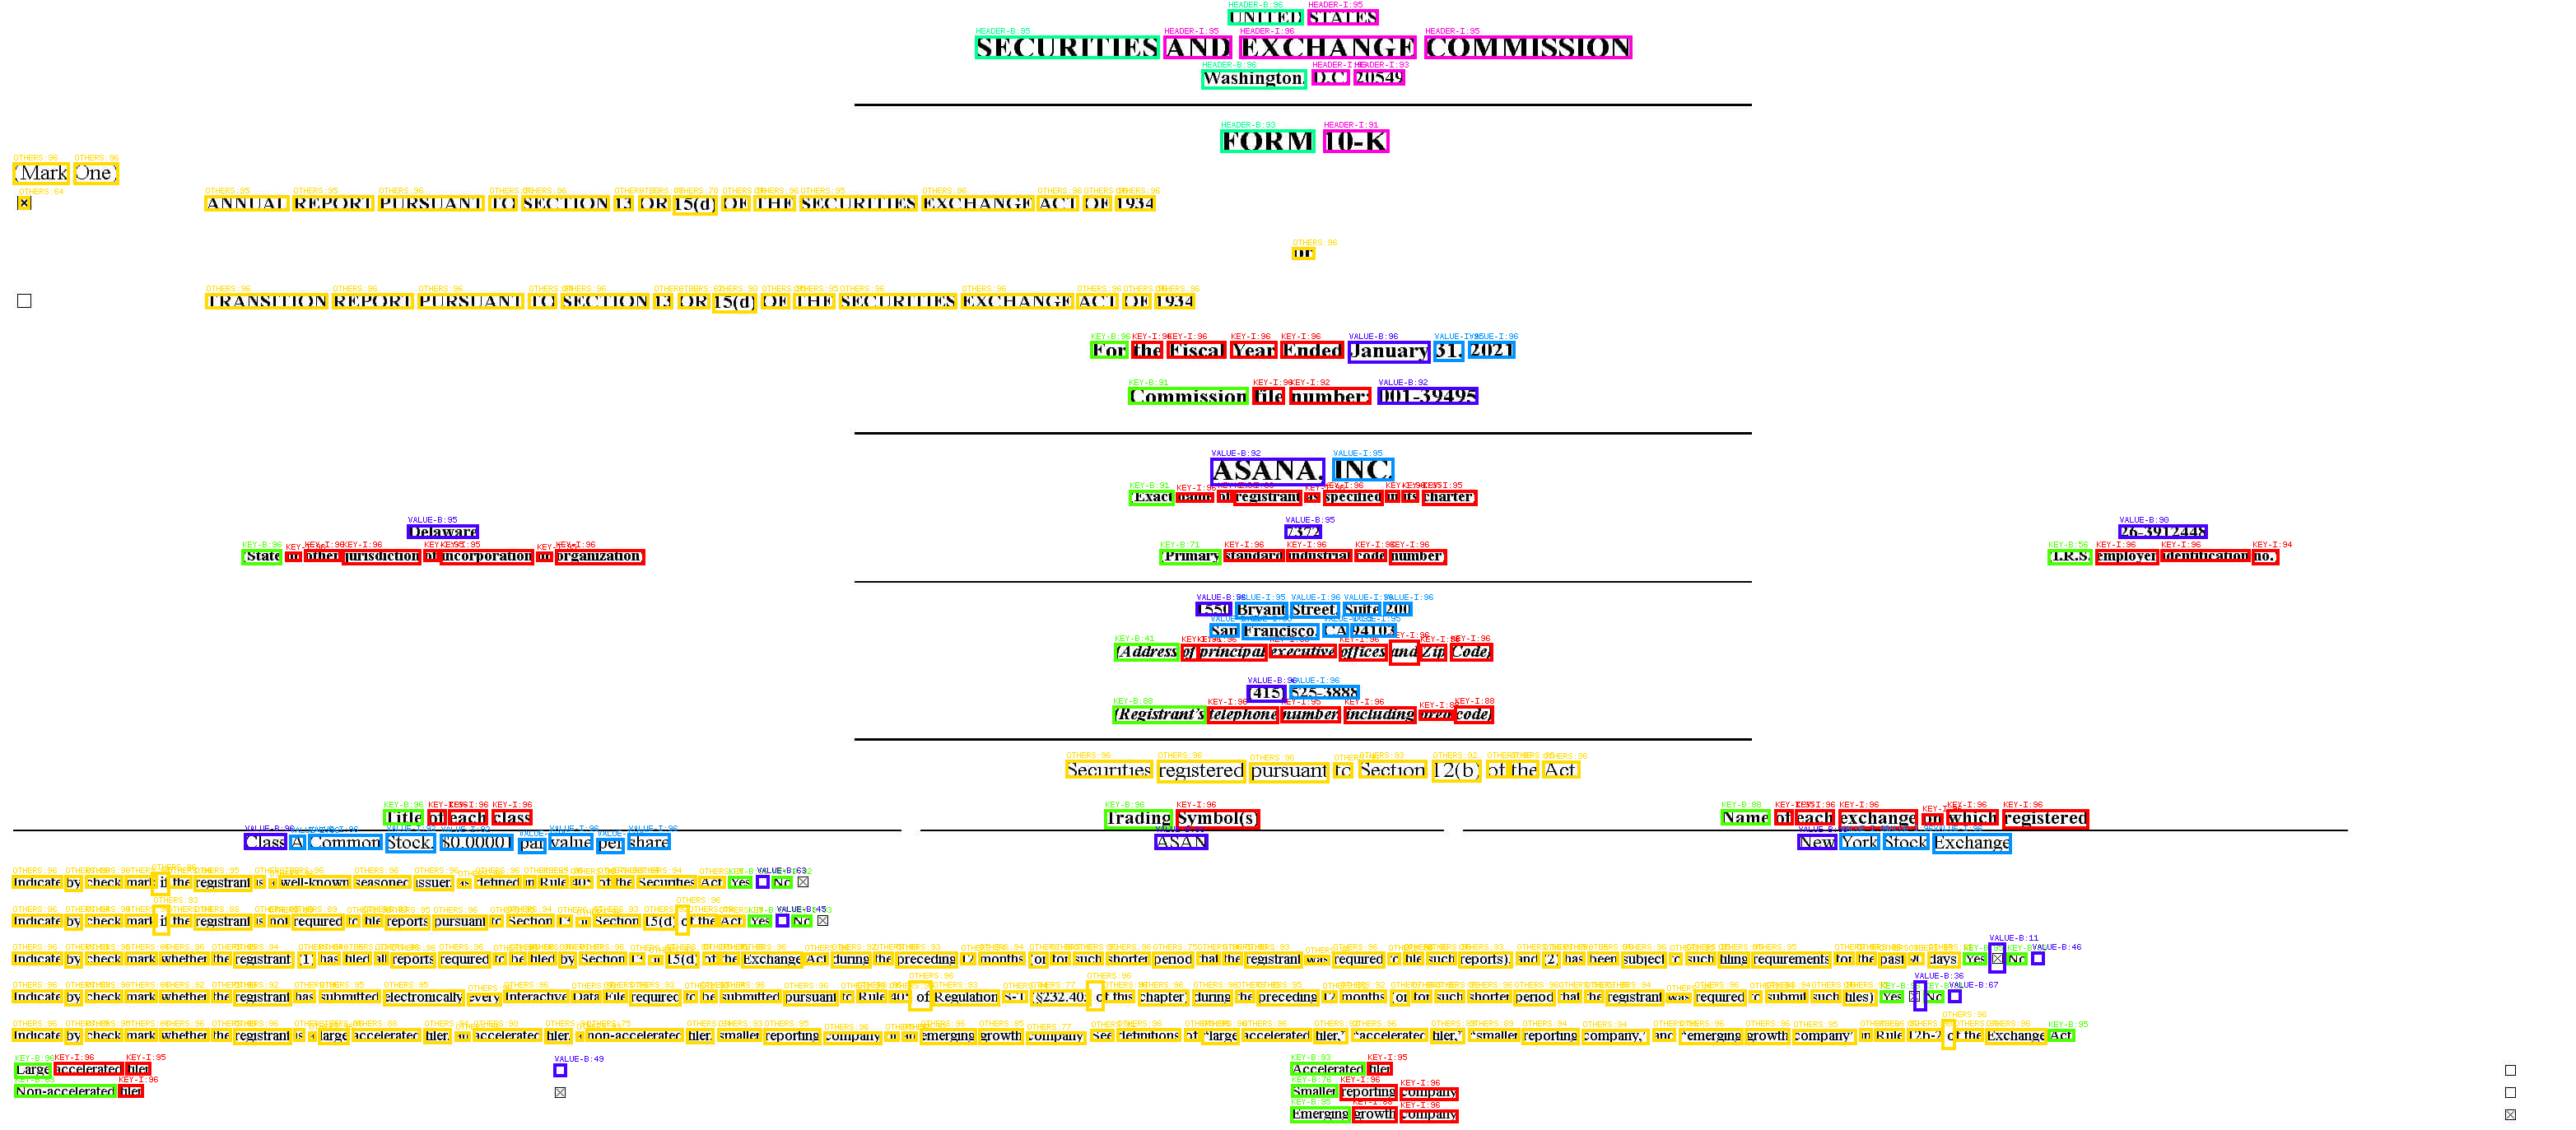

In [ ]:
visual.display_images(results, "image_with_annotations", width=1000)

In [ ]:
results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities.result")\
    .distinct().show(truncate=False)

+--------+--------+
|filename|result  |
+--------+--------+
|t01.jpg |VALUE-B |
|t01.jpg |KEY-B   |
|t01.jpg |HEADER-B|
|t01.jpg |VALUE-I |
|t01.jpg |OTHERS  |
|t01.jpg |KEY-I   |
|t01.jpg |HEADER-I|
+--------+--------+

